In [1]:
%load_ext autoreload
%autoreload 2

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.aqua.utils.backend_utils import is_aer_provider
from qiskit.aqua.components.variational_forms import VariationalForm

import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import sqrt, pi
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from qiskit import IBMQ
IBMQ.save_account('78a4e395a27e3cce2d6bea6321d4b618bacc9db3c5f4506850b2616b7444da36b01e2c0d1f27119c77dbbde833366731ea64401e8fab2f852fa84a4c4317a11b', overwrite=True)

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
nqubits = 4
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_valencia


In [3]:
dist = 1.1
driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
molecule = driver.run()
repulsion_energy = molecule.nuclear_repulsion_energy
num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
qubitOp = ferOp.mapping(map_type='parity')
qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
exact_solution = NumPyEigensolver(qubitOp).run()
#exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
#print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
#print(num_spin_orbitals, num_particles)
initial_state = HartreeFock(
    num_spin_orbitals,
    num_particles,
    qubit_mapping='parity'
)
var_form = UCCSD(
    num_orbitals=num_spin_orbitals,
    num_particles=num_particles,
    initial_state=initial_state,
    qubit_mapping='parity',
    excitation_type="s"
)

from qiskit.aqua.operators import (OperatorBase, ExpectationBase, ExpectationFactory, StateFn,
                                   CircuitStateFn, LegacyBaseOperator, ListOp, I, CircuitSampler)
backend = BasicAer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=None,
                                   coupling_map=None,
                                   measurement_error_mitigation_cls=None,
                                   cals_matrix_refresh_period=30)

In [4]:
from time import time
def _energy_evaluation(qubitOp, var_form, quantum_instance, x, y):
    """Evaluate energy at given parameters for the variational form.

    This is the objective function to be passed to the optimizer that is used for evaluation.

    Args:
        parameters: The parameters for the variational form.

    Returns:
        Energy of the hamiltonian of each parameter.


    Raises:
        RuntimeError: If the variational form has no parameters.
    """
    num_parameters = var_form.num_parameters
    _var_form_params = ParameterVector('θ', length=var_form.num_parameters)
    wave_function = var_form.construct_circuit(_var_form_params)
    expectation = ExpectationFactory.build(operator=qubitOp.to_opflow(), backend=quantum_instance, include_custom=False)
    observable_meas = expectation.convert(StateFn(qubitOp.to_opflow(), is_measurement=True))
    ansatz_circuit_op = CircuitStateFn(wave_function)

    parameter_sets = np.reshape(np.array([x,y]), (-1, num_parameters))
    # Create dict associating each parameter with the lists of parameterization values for it
    param_bindings = dict(zip(_var_form_params, parameter_sets.transpose().tolist()))  # type: Dict
    _circuit_sampler = CircuitSampler(quantum_instance, param_qobj=is_aer_provider(quantum_instance.backend))
    expect_op = observable_meas.compose(ansatz_circuit_op).reduce()

    start_time = time()
    sampled_expect_op = _circuit_sampler.convert(expect_op, params=param_bindings)
    means = np.real(sampled_expect_op.eval())
    end_time = time()
    
    #print('Energy evaluation returned {} - {} (ms)'.format(means[0], (end_time - start_time) * 1000))

    return means if len(means) > 1 else means[0]

In [5]:
import numpy as np
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [6]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']


In [9]:
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=None,
                                   measurement_error_mitigation_cls=None,
                                   cals_matrix_refresh_period=30)

n = 100
x = np.linspace(-pi, pi, n)
y = np.linspace(-pi, pi, n)
X, Y = np.meshgrid(x, y)
sim_E = np.zeros(X.shape)
for i in range(len(x)):
    print(i)
    for j in range(len(y)):
        sim_E[i,j] = _energy_evaluation(qubitOp, var_form, quantum_instance, x[i], y[j])

optimizer = COBYLA(maxiter=1000)
vqe = VQE(qubitOp, var_form, optimizer=optimizer)
ret = vqe.run(backend)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3ec69df50>>


In [12]:
ret

{'optimal_parameters': {Parameter(θ[0]): 0.00014372540381174187, Parameter(θ[1]): 0.0001002637482196646}, 'optimal_point': array([0.00014373, 0.00010026]), 'optimal_value': -1.5172121483632646, 'optimizer_evals': 30, 'optimizer_time': 1.395533800125122, 'eigenvalue': (-1.5172121483632646+0j), 'eigenstate': {'01': 1024}, 'cost_function_evals': 30}

/home/oryosu/anaconda3/envs/qiskit/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


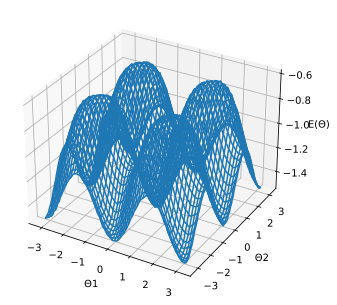

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("Θ1")
ax.set_ylabel("Θ2")
ax.set_zlabel("E(Θ)")
ax.plot_wireframe(X, Y, sim_E)
ax.plot([ret['optimal_point'][0]], [ret['optimal_point'][1]], [ret['eigenvalue']], marker="o",linestyle='None')
plt.show()

In [11]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.10, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']


In [13]:
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=None,
                                   measurement_error_mitigation_cls=None,
                                   cals_matrix_refresh_period=30)

n = 100
x = np.linspace(-pi, pi, n)
y = np.linspace(-pi, pi, n)
X, Y = np.meshgrid(x, y)
sim_E = np.zeros(X.shape)
for i in range(len(x)):
    print(i)
    for j in range(len(y)):
        sim_E[i,j] = _energy_evaluation(qubitOp, var_form, quantum_instance, x[i], y[j])

optimizer = COBYLA(maxiter=1000)
vqe = VQE(qubitOp, var_form, optimizer=optimizer)
ret = vqe.run(backend)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3e47e8310>>


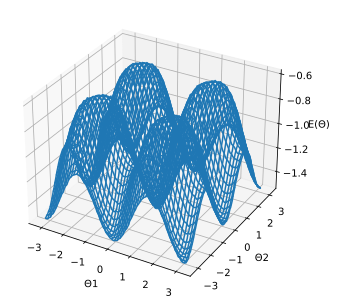

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("Θ1")
ax.set_ylabel("Θ2")
ax.set_zlabel("E(Θ)")
ax.plot_wireframe(X, Y, sim_E)
ax.plot([ret['optimal_point'][0]], [ret['optimal_point'][1]], [ret['eigenvalue']], marker="o",linestyle='None')
plt.show()

In [15]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.30, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=None,
                                   measurement_error_mitigation_cls=None,
                                   cals_matrix_refresh_period=30)

n = 100
x = np.linspace(-pi, pi, n)
y = np.linspace(-pi, pi, n)
X, Y = np.meshgrid(x, y)
sim_E = np.zeros(X.shape)
for i in range(len(x)):
    print(i)
    for j in range(len(y)):
        sim_E[i,j] = _energy_evaluation(qubitOp, var_form, quantum_instance, x[i], y[j])

optimizer = COBYLA(maxiter=1000)
vqe = VQE(qubitOp, var_form, optimizer=optimizer)
ret = vqe.run(backend)

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3e47a90d0>>


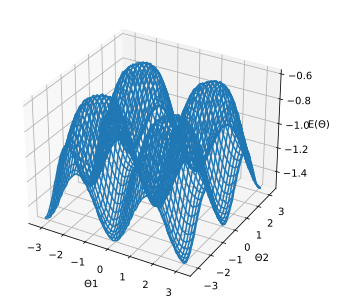

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("Θ1")
ax.set_ylabel("Θ2")
ax.set_zlabel("E(Θ)")
ax.plot_wireframe(X, Y, sim_E)
ax.plot([ret['optimal_point'][0]], [ret['optimal_point'][1]], [ret['eigenvalue']], marker="o",linestyle='None')
plt.show()

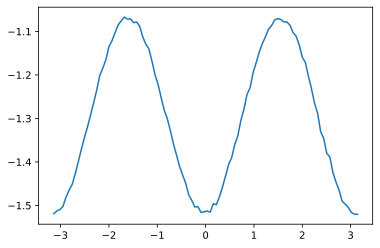

In [17]:
plt.plot(X[50, :], sim_E[50, :])

In [27]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.30, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=None,
                                   measurement_error_mitigation_cls=None,
                                   cals_matrix_refresh_period=30)

distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = COBYLA(maxiter=1000)
for dist in distances:
    driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity',
        excitation_type = 's'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3ec744350>>
Interatomic Distance: 0.5 VQE Result: -1.0412798056032304 Exact Energy: [-1.05515979]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3ec789790>>
Interatomic Distance: 0.6 VQE Result: -1.1019136621162353 Exact Energy: [-1.11628601]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3ec622c90>>
Interatomic Distance: 0.7 VQE Result: -1.1048901178855597 Exact Energy: [-1.13618945]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3e48c80d0>>
Interatomic Distance: 0.8 VQE Result: -1.1112680920637068 Exact Energy: [-1.13414767]
<bound method VQE._energy_ev

In [23]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmqx2")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=coupling_map,
                                   measurement_error_mitigation_cls=CompleteMeasFitter,
                                   cals_matrix_refresh_period=30)

distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies_real = []
optimizer = COBYLA(maxiter=1000)
for dist in distances:
    driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity',
        excitation_type = 's'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
    vqe_energies_real.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3ec668c90>>
Interatomic Distance: 0.5 VQE Result: -0.9894071480646989 Exact Energy: [-1.05515979]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3ec6ba410>>
Interatomic Distance: 0.6 VQE Result: -1.0794901393939755 Exact Energy: [-1.11628601]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3ec66b510>>
Interatomic Distance: 0.7 VQE Result: -1.08824730254954 Exact Energy: [-1.13618945]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3e4a53b50>>
Interatomic Distance: 0.8 VQE Result: -1.1050373242085434 Exact Energy: [-1.13414767]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3ee310450>>
Interatomic Distance: 0.9 VQE Result: -1.072047142316

In [26]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.50, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=None,
                                   measurement_error_mitigation_cls=None,
                                   cals_matrix_refresh_period=30)
distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies_5 = []
optimizer = COBYLA(maxiter=1000)
for dist in distances:
    driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity',
        excitation_type = 's'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
    vqe_energies_5.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3ec789290>>
Interatomic Distance: 0.5 VQE Result: -1.0413983805767433 Exact Energy: [-1.05515979]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3ec789cd0>>
Interatomic Distance: 0.6 VQE Result: -1.104436589487466 Exact Energy: [-1.11628601]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3e43eb850>>
Interatomic Distance: 0.7 VQE Result: -1.11440289183263 Exact Energy: [-1.13618945]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa446ef0c10>>
Interatomic Distance: 0.8 VQE Result: -1.111220813009702 Exact Energy: [-1.13414767]
<bound method VQE._energy_evalua

In [28]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.10, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=4096, 
                                   noise_model=noise_model,
                                   coupling_map=None,
                                   measurement_error_mitigation_cls=None,
                                   cals_matrix_refresh_period=30)
distances = np.arange(0.5, 2.0, 0.1)
exact_energies = []
vqe_energies_1 = []
optimizer = COBYLA(maxiter=1000)
for dist in distances:
    driver = PySCFDriver(atom='H .0 .0 -{}; H .0 .0 {}'.format(str(dist/2),str(dist/2)), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubitOp = ferOp.mapping(map_type='parity')
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    exact_solution = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(exact_solution.eigenvalues) + repulsion_energy)
    #print("Exact Result:", np.real(exact_solution.eigenvalues) + molecule.nuclear_repulsion_energy)
    #print(num_spin_orbitals, num_particles)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    )
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity',
        excitation_type = 's'
    )
    vqe = VQE(qubitOp, var_form, optimizer=optimizer)
    ret = vqe.run(quantum_instance)
    vqe_result = np.real(ret['eigenvalue']+ repulsion_energy)
    vqe_energies_1.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa44000b490>>
Interatomic Distance: 0.5 VQE Result: -1.0468717143357071 Exact Energy: [-1.05515979]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa3ec6abc10>>
Interatomic Distance: 0.6 VQE Result: -1.0977214916618785 Exact Energy: [-1.11628601]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa4408b8590>>
Interatomic Distance: 0.7 VQE Result: -1.1128915011137495 Exact Energy: [-1.13618945]
<bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.minimum_eigen_solvers.vqe.VQE object at 0x7fa44000b750>>
Interatomic Distance: 0.8 VQE Result: -1.1085163191099552 Exact Energy: [-1.13414767]
<bound method VQE._energy_ev

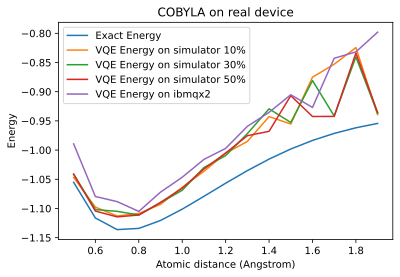

In [31]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies_1, label="VQE Energy on simulator 10%")
plt.plot(distances, vqe_energies, label="VQE Energy on simulator 30%")
plt.plot(distances, vqe_energies_5, label="VQE Energy on simulator 50%")
plt.plot(distances, vqe_energies_real, label="VQE Energy on ibmqx2")
#plt.plot(distances, np.mean(results, axis=0), label='Average')
#plt.errorbar(distances, np.mean(results, axis=0), yerr = np.std(results, ddof=1, axis=0)/ np.sqrt(len(results[0])), fmt='o', markersize=1, ecolor='black', markeredgecolor = "black", color='w')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.title("COBYLA on real device")
plt.legend()
plt.savefig("H2_simu_e.png")
plt.show()